# 2024 CITS4012 Project

# ReadMme

# 1. Dataset Processing

## Importing Libraries

In [35]:
import re
import json
# import nltk
import time
import math
import spacy
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gensim.downloader as api
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

## Loading Datasets

In [36]:
# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [37]:
# Load the training data
# with open('/content/drive/MyDrive/data/train.json', 'r') as file:
with open('train.json', 'r') as file:
    data = json.load(file)
    train_data = pd.DataFrame(data['data'], columns=data['columns'])

# Load the test data
# with open('/content/drive/MyDrive/data/test.json', 'r') as file:
with open('test.json', 'r') as file:
    data = json.load(file)
    test_data = pd.DataFrame(data['data'], columns=data['columns'])

# Load the validation data
# with open('/content/drive/MyDrive/data/val.json', 'r') as file:
with open('val.json', 'r') as file:
    data = json.load(file)
    val_data = pd.DataFrame(data['data'], columns=data['columns'])

# Get the x and y lists for training data and test data
training_x = train_data['sentence'].tolist() + val_data['sentence'].tolist()
training_a = train_data['aspect'].tolist() + val_data['aspect'].tolist()
training_y = train_data['polarity'].tolist() + val_data['polarity'].tolist()
test_x = test_data['sentence'].tolist()
test_a = test_data['aspect'].tolist()
test_y = test_data['polarity'].tolist()

## Dataset Analysis

In [38]:
# Size of datasets
print("Training data size :", len(training_x))
print("Test data size     :", len(test_x))

# Aspect Distribution
aspect_distribution = train_data['aspect'].value_counts()
print("\nAspect Distribution:")
print(aspect_distribution.to_string(header=False))

# Polarity Distribution
polarity_distribution = train_data['polarity'].value_counts()
print("\nPolarity Distribution:")
print(polarity_distribution.to_string(header=False))

# Aspect-Sentiment Pair Distribution
aspect_polarity_pair = [(a, p) for a, p in zip(train_data['aspect'], train_data['polarity'])]
aspect_polarity_freq = pd.Series(aspect_polarity_pair).value_counts()
print("\nAspect-Sentiment Pair Distribution:")
print(aspect_polarity_freq.to_string(header=False))

Training data size : 7978
Test data size     : 901

Aspect Distribution:
food             2307
staff            1383
miscellaneous     954
place             694
service           631
menu              475
ambience          324
price             322

Polarity Distribution:
neutral     3077
negative    2084
positive    1929

Aspect-Sentiment Pair Distribution:
(food, neutral)              1298
(staff, negative)             922
(food, positive)              754
(miscellaneous, neutral)      531
(place, neutral)              430
(menu, neutral)               372
(staff, positive)             332
(service, negative)           329
(food, negative)              255
(miscellaneous, positive)     227
(miscellaneous, negative)     196
(ambience, positive)          181
(service, positive)           174
(place, negative)             139
(price, neutral)              136
(staff, neutral)              129
(service, neutral)            128
(place, positive)             125
(price, negative)          

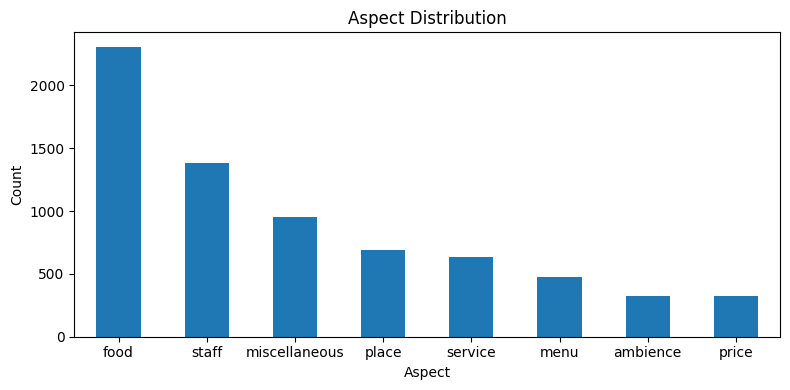

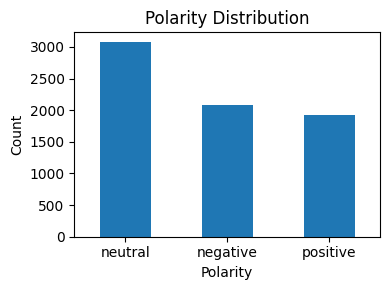

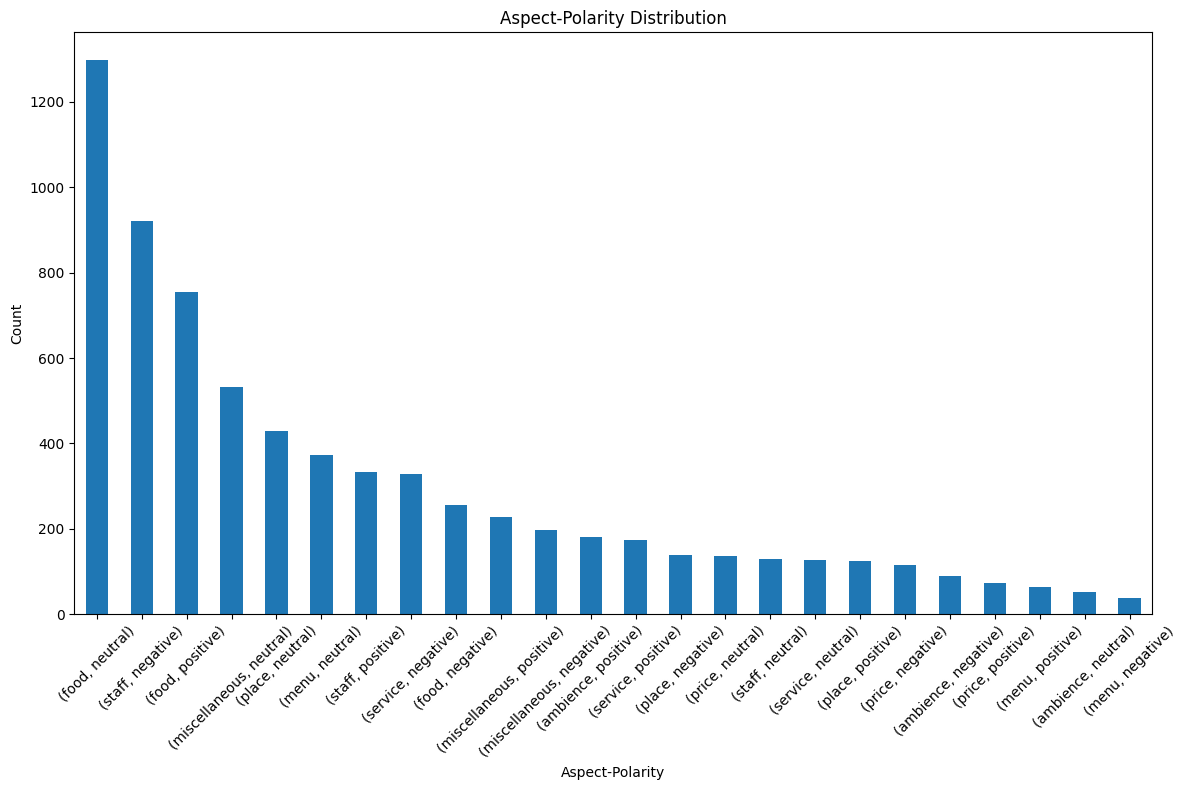

In [39]:
# Functiont to plot distribution bar graphs
def plot_distribution(figsize, distribution, title, xlabel, rotation=0):
    plt.figure(figsize=figsize)
    distribution.plot(kind='bar')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Count')
    plt.xticks(rotation=rotation)
    plt.tight_layout()
    plt.show()

# Plot Aspect Distribution
plot_distribution((8, 4), aspect_distribution, 'Aspect Distribution', 'Aspect')
# Plot Polarity Distribution
plot_distribution((4, 3), polarity_distribution, 'Polarity Distribution', 'Polarity')
# Plot Aspect-Polarity Distribution
plot_distribution((12, 8), aspect_polarity_freq, 'Aspect-Polarity Distribution', 'Aspect-Polarity', 45)

## Data Preprocessing

In [40]:
! python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 660.6 kB/s eta 0:00:20
      --------------------------------------- 0.2/12.8 MB 2.0 MB/s eta 0:00:07
      --------------------------------------- 0.3/12.8 MB 2.4 MB/s eta 0:00:06
     - -------------------------------------- 0.5/12.8 MB 2.6 MB/s eta 0:00:05
     - -------------------------------------- 0.6/12.8 MB 2.7 MB/s eta 0:00:05
     -- ------------------------------------- 0.7/12.8 MB 2.7 MB/s eta 0:00:05
     -- ------------------------------------- 0.8/12.8 MB 2.5 MB/s eta 0:00:05
     -- ------------------------------------- 0.8/12.8 MB 2.3 MB/s eta 0:00:06
     -- ------------------------------------- 0.8/12.8 MB 2.3 MB/s eta 0:00:06
     -- ------------------------------------- 0.8/12.8 MB 2.3 MB/s eta 0:00:06
     -- ------------------------------------- 0.9/12.8 MB 1.9 MB/s eta 0:00:07
     --- ------------------------------------ 1.0/12.8 MB 

In [41]:
# Punctuation Removal
def remove_punctuation_re(x):
    x = re.sub(r'[^\w\s]', '', x)
    return x

# Stopwords Removal
nlp = spacy.load("en_core_web_sm")

# Remove certain words from the stop words list
custom_stop_words = [
    "not", "no", "never", "neither", "nor",
    "nobody", "nothing", "nowhere", "none", "cannot", 
    "but"
]

for a in custom_stop_words:
    nlp.vocab[a].is_stop = False

# Perform Stopwords Removal, Lemmatisation and Tokenisation
def spacy_processing(x):
    doc = nlp(x)
    x = [word.lemma_ for word in doc if not word.is_stop]
    return x


# English Contractions Dictionary
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have",
                    "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us",
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have",
                    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
                    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
                    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

# Emoticons
EMOTICONS = r"""
    (?:
      [<>]?
      [:;=8]                     # eyes
      [\-o\*\']?                 # optional nose
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      |
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      [\-o\*\']?                 # optional nose
      [:;=8]                     # eyes
      [<>]?
      |
      <3                         # heart
    )"""

EMOTICON_RE = re.compile(EMOTICONS, re.VERBOSE | re.I | re.UNICODE)

In [42]:
# Function to preprocess the data
def preprocess_data(sentence_list):
    output_list = []
    for sentence in sentence_list:
        emoticons = EMOTICON_RE.findall(sentence)       # Extract emoticons
        sentence = EMOTICON_RE.sub('', sentence)        # Remove emoticons
        sentence = sentence.lower()                     # Case folding
        for word, new_word in contraction_dict.items(): # Deal with contractions
            sentence = sentence.replace(word, new_word)
        sentence = remove_punctuation_re(sentence)      # Remove punctuation
        tokens = spacy_processing(sentence)             # Remove stopwords / Lemmatisation / Tokenise
        tokens.extend(emoticons)                        # Add emoticons back
        output_list.append(tokens)
    return output_list

# Preprocess the data and get the tokenised sentence lists
train_x_token = preprocess_data(training_x)
test_x_token = preprocess_data(test_x)

## Create Word Vocabulary

In [43]:
# Get longest sentence length
longest_sentence = max(train_x_token, key=len)
MAX_LENGTH = len(longest_sentence)

# Word vocabulary to index dictionary {word: index}
word_to_idx = {'<PAD>': 0, '<SEP>': 1}
review = train_x_token + test_x_token
aspect = [list(set(training_a))]
polarity = [list(set(training_y))]

# Vocabulary includes words from reviews and aspects
for sentence in aspect+review:
    for word in sentence:
        if word not in word_to_idx:
            word_to_idx[word] = len(word_to_idx)
word_list = list(word_to_idx.keys())
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
vocab_size = len(word_to_idx)

# Polarity vocabulary to index dictionary {polarity: index}
polarity_to_idx = {p: i for i, p in enumerate(polarity[0])}
idx_to_polarity = {idx: pol for pol, idx in polarity_to_idx.items()}

## Convert Words to Index form

In [44]:
def list_to_index(token_list, word_to_idx):
    idx_list = []
    for tokens in token_list:
        idx_list.append([word_to_idx[token] for token in tokens])
    return idx_list

def string_to_index(aspect_list, word_to_idx):
    idx_list = []
    for aspect in aspect_list:
        idx_list.append(word_to_idx[aspect])
    return idx_list

# Append aspect to the end of the sentence
def combine_sentence_aspect(sentence, aspect, has_sep):
    if has_sep:
        sep_idx = word_to_idx['<SEP>']
        combined_idx = sentence + [sep_idx] + [aspect]
    else:
        combined_idx = sentence + [aspect]
    return combined_idx

# Append aspect after every word
def combine_repeat_aspect(sentence, aspect, has_sep):
    output = []
    for word in sentence:
        if has_sep:
            sep_idx = word_to_idx['<SEP>']
            output = output + [word] + [sep_idx] + [aspect]
        else:
            output = output + [word] + [aspect]
    return output

# Token index lists for training data
train_x_idx = list_to_index(train_x_token, word_to_idx)
train_a_idx = string_to_index(training_a, word_to_idx)
train_y_idx = string_to_index(training_y, polarity_to_idx)

# Max length of the sentence after appending aspect
MAX_COMBINED_LENGTH = MAX_LENGTH + 1
MAX_REP_LENGTH = MAX_LENGTH*2
MAX_REPSEP_LENGTH = MAX_LENGTH*3

## Pretrained Word Embeddings from Glove

In [45]:
# Get Weights for the Embedding Layer (GloVe)
embedding_size = 100
glove_model = api.load("glove-twitter-100")
glove_weights = np.zeros((vocab_size, embedding_size))
for i, word in enumerate(word_to_idx.keys()):
    try:
        # If word in glove, get the weights
        glove_weights[i] = glove_model[word]
    except:
        # If word not in glove, initialise with random weights
        glove_weights[i] = np.random.uniform(low=-0.1, high=0.1, size=embedding_size)

# 2. Model Implementation

## Model Variants

In [46]:
# Different aspect integration
NO_ASPECT       = 'no aspect'
ASPECT_EMBED    = 'aspect embedding'
WITH_SEP        = 'with separator'
NO_SEP          = 'no separator'
ASPECT_REP_SEP  = 'aspect repeat with separator'
ASPECT_REP      = 'aspect repeat'

# Different attention mechanisms
ATTN_NONE       = 'no_attention'
ATTN_DOT        = 'dot_product'
ATTN_SCALE_DOT  = 'scaled_dot_product'
ATTN_COSINE     = 'cosine_similarity'

In [47]:
# Model
class Model(nn.Module):
    def __init__(self, hidden_size, output_size, embedding, integration, attention='dot_product', num_layers=1):
        super(Model, self).__init__()
        self.integration_type = integration
        self.attention_type = attention
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding = embedding
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers)
        self.linear_attention = nn.Linear(self.hidden_size*2, self.output_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def attention(self, hidden, encoder_hiddens):
        if self.attention_type == ATTN_DOT:            # Dot product attention
            attn_weights = F.softmax(torch.bmm(hidden, encoder_hiddens.T.unsqueeze(0)), dim=-1)
        elif self.attention_type == ATTN_SCALE_DOT:   # Scaled dot product attention
            scale = 1.0 / np.sqrt(self.hidden_size)
            attn_weights = F.softmax(torch.bmm(hidden, encoder_hiddens.T.unsqueeze(0)) * scale, dim=-1)
        elif self.attention_type == ATTN_COSINE:    # Cosine similarity attention
            query = hidden / torch.norm(hidden, dim=-1)
            keys = encoder_hiddens / torch.norm(encoder_hiddens.T, dim=-1)
            norm_product = torch.bmm(query, keys.T.unsqueeze(0))
            attn_weights = F.softmax(norm_product, dim=-1)
        attn_output = torch.bmm(attn_weights, encoder_hiddens.unsqueeze(0))
        concat_output = torch.cat((attn_output[0], hidden[0]), 1)
        output = F.log_softmax(self.linear_attention(concat_output), dim=1)
        return output, attn_weights
            
    def forward(self, input, hidden, cell, encoder_hiddens, aspect, is_last):
        word_embedding = self.embedding(input).view(1, 1, -1)
        if self.integration_type in [WITH_SEP, NO_SEP, ASPECT_REP_SEP, ASPECT_REP, NO_ASPECT]:
            output, (hidden, cell) = self.lstm(word_embedding, (hidden, cell))
        elif self.integration_type == ASPECT_EMBED:
            aspect_embedding = self.embedding(aspect).view(1, 1, -1)
            embedded = torch.cat((aspect_embedding, word_embedding), 0)
            output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        
        attn_weights = None
        if is_last: # Attention Mechanism and generate output
            if self.attention_type == ATTN_NONE:
                output = F.log_softmax(self.linear(output[0]), dim=1)
                attn_weights = None
            else:
                output, attn_weights = self.attention(hidden, encoder_hiddens)
        return output, (hidden, cell), attn_weights

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size)

In [48]:
# Function to get time elapse for training
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

# Function to feed input tensor
def feed_encoder(encoder, input_tensor, aspect_tensor, max_length):
    hiddens = torch.zeros(max_length, encoder.hidden_size)  # For attention mechanism
    hidden = encoder.init_hidden()                          # Hidden state
    cell = encoder.init_hidden()                            # Cell state
    for i in range(input_tensor.size(0)):
        is_last = (i==input_tensor.size(0)-1)
        if is_last:
            y_output, (_, _), _ = encoder(input_tensor[i], hidden, cell, hiddens, aspect_tensor, is_last=is_last)
        else:
            _, (hidden, cell), _ = encoder(input_tensor[i], hidden, cell, hiddens, aspect_tensor, is_last=is_last)
            hiddens[i] = hidden[0, 0]    
    return y_output

# Function to prepare input tensors for different integration types
def prepare_input_tensors(sent_idx, asp_idx, combine_function):
    # Combine sentence and aspect
    combined = combine_function(sent_idx, asp_idx, has_sep=False)
    index = [[idx] for idx in combined]
    tensor = torch.LongTensor(index)
    # Combine sentence and aspect with separator
    combined_sep = combine_function(sent_idx, asp_idx, has_sep=True)
    sep_index = [[idx] for idx in combined_sep]
    sep_tensor = torch.LongTensor(sep_index)
    return tensor, sep_tensor

# Function to prepare data for training
def prepare_data(random_idx):
    # Input data - sentence
    x_index = [[idx] for idx in train_x_idx[random_idx]]
    x_tensor = torch.LongTensor(x_index)
    # Input data - aspect
    a_index = train_a_idx[random_idx]
    a_tensor = torch.LongTensor([a_index])
    # Input data - aspect integrated
    x_temp = train_x_idx[random_idx]
    xa_tensor, xa_sep_tensor = prepare_input_tensors(x_temp, a_index, combine_sentence_aspect)
    xar_tensor, xar_sep_tensor = prepare_input_tensors(x_temp, a_index, combine_repeat_aspect)
    # Target data
    y_index = train_y_idx[random_idx]
    y_tensor = torch.LongTensor([y_index])
    return x_tensor, a_tensor, xa_tensor, xa_sep_tensor, xar_tensor, xar_sep_tensor, y_tensor

In [49]:
# Function to train model
def train(embedding, attention_type, integration_type,
          num_epochs=10000, 
          print_interval=500, 
          plot_interval=200, 
          learning_rate=0.001, 
          hidden_size=100):
    
    model = Model(hidden_size, 3, embedding, integration_type, attention_type, num_layers=1)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    plot_avg_losses, print_loss_total, plot_loss_total = [], 0, 0
    start = time.time()

    for epoch in range(1, num_epochs+1):
        random_idx = random.choice(range(len(train_data)))
        x_tensor, a_tensor, xa_tensor, xa_sep_tensor, xar_tensor, xar_sep_tensor, y_tensor = prepare_data(random_idx)

        loss = 0
        model.train()
        optimizer.zero_grad()
        
        # Feed the input tensor into the encoder
        if integration_type == NO_ASPECT:
            y_output = feed_encoder(model, x_tensor, a_tensor, MAX_LENGTH)
        elif integration_type == WITH_SEP:
            y_output = feed_encoder(model, xa_sep_tensor, a_tensor, MAX_COMBINED_LENGTH+1)
        elif integration_type == ASPECT_EMBED:
            y_output = feed_encoder(model, x_tensor, a_tensor, MAX_LENGTH)
        elif integration_type == NO_SEP:
            y_output = feed_encoder(model, xa_tensor, a_tensor, MAX_COMBINED_LENGTH)
        elif integration_type == ASPECT_REP_SEP:
            y_output = feed_encoder(model, xar_sep_tensor, a_tensor, MAX_REPSEP_LENGTH)
        elif integration_type == ASPECT_REP:
            y_output = feed_encoder(model, xar_tensor, a_tensor, MAX_REP_LENGTH)

        loss += criterion(y_output, y_tensor)

        # Backpropagation
        loss.backward()
        optimizer.step()
        
        print_loss_total += loss.item()
        plot_loss_total += loss.item()
        
        if epoch % print_interval == 0:
            print_avg_loss = print_loss_total / print_interval
            print_time = timeSince(start, epoch / num_epochs)
            print(f'{print_time} Epoch [{epoch}/{num_epochs}] Loss: {print_avg_loss:.4f}')
            print_loss_total = 0
            
        if epoch % plot_interval == 0:
            plot_avg_loss = plot_loss_total / plot_interval
            plot_avg_losses.append(plot_avg_loss)
            plot_loss_total = 0
            
    return model, plot_avg_losses

# Function to plot average loss graph over epochs
def plot_graphs(num_epochs, interval, plot_avg_losses):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs+1, interval), plot_avg_losses)
    plt.title('Average Losses over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.show()

## Selected Hyperparameters

In [50]:
# Set hyperparameters
num_epochs       = 10000
print_interval   = 500
plot_interval    = 200
learning_rate    = 0.001
hidden_size      = 100

# Get word embeddings
embedding = nn.Embedding(vocab_size, hidden_size)
embedding.weight.data.copy_(torch.from_numpy(glove_weights))
print(embedding.weight.data.shape)

torch.Size([6152, 100])


## Aspect Repeat no Separator

In [51]:
# Set different attention and integration types
attention_type   = ATTN_DOT
integration_type = ASPECT_REP

# Train the model
model0, plot_avg_losses0 = train(embedding, attention_type, integration_type, num_epochs=num_epochs, learning_rate=learning_rate, hidden_size=hidden_size)

0m 9s (- 3m 1s) Epoch [500/10000] Loss: 0.9780
0m 19s (- 2m 56s) Epoch [1000/10000] Loss: 0.9239
0m 30s (- 2m 54s) Epoch [1500/10000] Loss: 0.9210
0m 40s (- 2m 43s) Epoch [2000/10000] Loss: 0.9033
0m 51s (- 2m 34s) Epoch [2500/10000] Loss: 0.9499
1m 1s (- 2m 23s) Epoch [3000/10000] Loss: 0.8343
1m 11s (- 2m 12s) Epoch [3500/10000] Loss: 0.8027
1m 21s (- 2m 2s) Epoch [4000/10000] Loss: 0.8377
1m 32s (- 1m 52s) Epoch [4500/10000] Loss: 0.8496
1m 42s (- 1m 42s) Epoch [5000/10000] Loss: 0.8369
1m 52s (- 1m 32s) Epoch [5500/10000] Loss: 0.8174
2m 3s (- 1m 22s) Epoch [6000/10000] Loss: 0.8498
2m 13s (- 1m 11s) Epoch [6500/10000] Loss: 0.7527
2m 24s (- 1m 1s) Epoch [7000/10000] Loss: 0.7719
2m 34s (- 0m 51s) Epoch [7500/10000] Loss: 0.6900
2m 44s (- 0m 41s) Epoch [8000/10000] Loss: 0.7286
2m 55s (- 0m 30s) Epoch [8500/10000] Loss: 0.6936
3m 6s (- 0m 20s) Epoch [9000/10000] Loss: 0.7205
3m 16s (- 0m 10s) Epoch [9500/10000] Loss: 0.7333
3m 26s (- 0m 0s) Epoch [10000/10000] Loss: 0.7306


## Aspect Repeat with Separator

In [52]:
# Set different attention and integration types
attention_type   = ATTN_DOT
integration_type = ASPECT_REP_SEP

# Train the model
model1, plot_avg_losses1 = train(embedding, attention_type, integration_type, num_epochs=num_epochs, learning_rate=learning_rate, hidden_size=hidden_size)

0m 14s (- 4m 34s) Epoch [500/10000] Loss: 0.9942
0m 28s (- 4m 20s) Epoch [1000/10000] Loss: 0.9217
0m 42s (- 4m 3s) Epoch [1500/10000] Loss: 0.8944
0m 56s (- 3m 47s) Epoch [2000/10000] Loss: 0.8658
1m 10s (- 3m 32s) Epoch [2500/10000] Loss: 0.8575
1m 24s (- 3m 17s) Epoch [3000/10000] Loss: 0.8367
1m 38s (- 3m 3s) Epoch [3500/10000] Loss: 0.7607
1m 52s (- 2m 49s) Epoch [4000/10000] Loss: 0.7962
2m 6s (- 2m 34s) Epoch [4500/10000] Loss: 0.7770
2m 20s (- 2m 20s) Epoch [5000/10000] Loss: 0.7271
2m 34s (- 2m 6s) Epoch [5500/10000] Loss: 0.7728
2m 48s (- 1m 52s) Epoch [6000/10000] Loss: 0.7826
3m 2s (- 1m 38s) Epoch [6500/10000] Loss: 0.6908
3m 16s (- 1m 24s) Epoch [7000/10000] Loss: 0.6672
3m 31s (- 1m 10s) Epoch [7500/10000] Loss: 0.6564
3m 44s (- 0m 56s) Epoch [8000/10000] Loss: 0.7138
3m 59s (- 0m 42s) Epoch [8500/10000] Loss: 0.6097
4m 12s (- 0m 28s) Epoch [9000/10000] Loss: 0.6782
4m 26s (- 0m 14s) Epoch [9500/10000] Loss: 0.6604
4m 40s (- 0m 0s) Epoch [10000/10000] Loss: 0.6077


## Aspect Embedding

In [53]:
# Set different attention and integration types
attention_type   = ATTN_DOT
integration_type = ASPECT_EMBED

# Train the model
model2, plot_avg_losses2 = train(embedding, attention_type, integration_type, num_epochs=num_epochs, learning_rate=learning_rate, hidden_size=hidden_size)

0m 7s (- 2m 14s) Epoch [500/10000] Loss: 0.9325
0m 14s (- 2m 7s) Epoch [1000/10000] Loss: 0.7715
0m 21s (- 1m 59s) Epoch [1500/10000] Loss: 0.8202
0m 27s (- 1m 51s) Epoch [2000/10000] Loss: 0.7692
0m 34s (- 1m 43s) Epoch [2500/10000] Loss: 0.7461
0m 41s (- 1m 36s) Epoch [3000/10000] Loss: 0.7104
0m 48s (- 1m 30s) Epoch [3500/10000] Loss: 0.6977
0m 55s (- 1m 23s) Epoch [4000/10000] Loss: 0.6698
1m 2s (- 1m 16s) Epoch [4500/10000] Loss: 0.6174
1m 9s (- 1m 9s) Epoch [5000/10000] Loss: 0.6367
1m 16s (- 1m 2s) Epoch [5500/10000] Loss: 0.6590
1m 22s (- 0m 55s) Epoch [6000/10000] Loss: 0.6547
1m 29s (- 0m 48s) Epoch [6500/10000] Loss: 0.6558
1m 36s (- 0m 41s) Epoch [7000/10000] Loss: 0.6059
1m 43s (- 0m 34s) Epoch [7500/10000] Loss: 0.6296
1m 50s (- 0m 27s) Epoch [8000/10000] Loss: 0.6611
1m 57s (- 0m 20s) Epoch [8500/10000] Loss: 0.5826
2m 4s (- 0m 13s) Epoch [9000/10000] Loss: 0.6509
2m 11s (- 0m 6s) Epoch [9500/10000] Loss: 0.5536
2m 18s (- 0m 0s) Epoch [10000/10000] Loss: 0.6090


## With Separator

In [54]:
# Set different attention and integration types
attention_type   = ATTN_DOT
integration_type = WITH_SEP

# Train the model
model3, plot_avg_losses3 = train(embedding, attention_type, integration_type, num_epochs=num_epochs, learning_rate=learning_rate, hidden_size=hidden_size)

0m 6s (- 2m 9s) Epoch [500/10000] Loss: 0.8823
0m 13s (- 2m 3s) Epoch [1000/10000] Loss: 0.8032
0m 20s (- 1m 56s) Epoch [1500/10000] Loss: 0.7309
0m 27s (- 1m 49s) Epoch [2000/10000] Loss: 0.7524
0m 34s (- 1m 43s) Epoch [2500/10000] Loss: 0.6831
0m 41s (- 1m 35s) Epoch [3000/10000] Loss: 0.5936
0m 47s (- 1m 29s) Epoch [3500/10000] Loss: 0.6211
0m 54s (- 1m 22s) Epoch [4000/10000] Loss: 0.6348
1m 1s (- 1m 15s) Epoch [4500/10000] Loss: 0.6209
1m 8s (- 1m 8s) Epoch [5000/10000] Loss: 0.5648
1m 15s (- 1m 1s) Epoch [5500/10000] Loss: 0.5676
1m 22s (- 0m 54s) Epoch [6000/10000] Loss: 0.5882
1m 29s (- 0m 47s) Epoch [6500/10000] Loss: 0.6544
1m 36s (- 0m 41s) Epoch [7000/10000] Loss: 0.4974
1m 43s (- 0m 34s) Epoch [7500/10000] Loss: 0.4620
1m 49s (- 0m 27s) Epoch [8000/10000] Loss: 0.5011
1m 56s (- 0m 20s) Epoch [8500/10000] Loss: 0.4725
2m 3s (- 0m 13s) Epoch [9000/10000] Loss: 0.5070
2m 10s (- 0m 6s) Epoch [9500/10000] Loss: 0.4769
2m 17s (- 0m 0s) Epoch [10000/10000] Loss: 0.4871


## No Aspect

In [55]:
# Set different attention and integration types
attention_type   = ATTN_DOT
integration_type = NO_ASPECT

# Train the model
model4, plot_avg_losses4 = train(embedding, attention_type, integration_type, num_epochs=num_epochs, learning_rate=learning_rate, hidden_size=hidden_size)

0m 6s (- 2m 1s) Epoch [500/10000] Loss: 1.0013
0m 12s (- 1m 54s) Epoch [1000/10000] Loss: 0.9055
0m 18s (- 1m 46s) Epoch [1500/10000] Loss: 0.8859
0m 25s (- 1m 40s) Epoch [2000/10000] Loss: 0.8594
0m 31s (- 1m 33s) Epoch [2500/10000] Loss: 0.8803
0m 37s (- 1m 26s) Epoch [3000/10000] Loss: 0.8835
0m 43s (- 1m 20s) Epoch [3500/10000] Loss: 0.8749
0m 49s (- 1m 14s) Epoch [4000/10000] Loss: 0.8605
0m 55s (- 1m 8s) Epoch [4500/10000] Loss: 0.8511
1m 2s (- 1m 2s) Epoch [5000/10000] Loss: 0.8593
1m 8s (- 0m 55s) Epoch [5500/10000] Loss: 0.8736
1m 14s (- 0m 49s) Epoch [6000/10000] Loss: 0.8598
1m 20s (- 0m 43s) Epoch [6500/10000] Loss: 0.8218
1m 26s (- 0m 37s) Epoch [7000/10000] Loss: 0.8263
1m 33s (- 0m 31s) Epoch [7500/10000] Loss: 0.8667
1m 39s (- 0m 24s) Epoch [8000/10000] Loss: 0.8365
1m 45s (- 0m 18s) Epoch [8500/10000] Loss: 0.8230
1m 51s (- 0m 12s) Epoch [9000/10000] Loss: 0.8477
1m 57s (- 0m 6s) Epoch [9500/10000] Loss: 0.8201
2m 3s (- 0m 0s) Epoch [10000/10000] Loss: 0.8190


## No Separator

In [56]:
# Set different attention and integration types
attention_type   = ATTN_DOT
integration_type = NO_SEP

# Train the model
model5, plot_avg_losses5 = train(embedding, attention_type, integration_type, num_epochs=num_epochs, learning_rate=learning_rate, hidden_size=hidden_size)

0m 6s (- 2m 7s) Epoch [500/10000] Loss: 0.8526
0m 13s (- 1m 58s) Epoch [1000/10000] Loss: 0.7394
0m 19s (- 1m 52s) Epoch [1500/10000] Loss: 0.6453
0m 26s (- 1m 45s) Epoch [2000/10000] Loss: 0.6795
0m 32s (- 1m 38s) Epoch [2500/10000] Loss: 0.6474
0m 39s (- 1m 31s) Epoch [3000/10000] Loss: 0.6038
0m 45s (- 1m 25s) Epoch [3500/10000] Loss: 0.5970
0m 52s (- 1m 18s) Epoch [4000/10000] Loss: 0.6127
0m 58s (- 1m 11s) Epoch [4500/10000] Loss: 0.5341
1m 5s (- 1m 5s) Epoch [5000/10000] Loss: 0.4932
1m 12s (- 0m 59s) Epoch [5500/10000] Loss: 0.4836
1m 18s (- 0m 52s) Epoch [6000/10000] Loss: 0.4800
1m 25s (- 0m 45s) Epoch [6500/10000] Loss: 0.5231
1m 32s (- 0m 39s) Epoch [7000/10000] Loss: 0.4537
1m 39s (- 0m 33s) Epoch [7500/10000] Loss: 0.4737
1m 46s (- 0m 26s) Epoch [8000/10000] Loss: 0.4306
1m 52s (- 0m 19s) Epoch [8500/10000] Loss: 0.4189
1m 59s (- 0m 13s) Epoch [9000/10000] Loss: 0.4863
2m 6s (- 0m 6s) Epoch [9500/10000] Loss: 0.4193
2m 12s (- 0m 0s) Epoch [10000/10000] Loss: 0.4142


## Visualisation of average loss over epochs

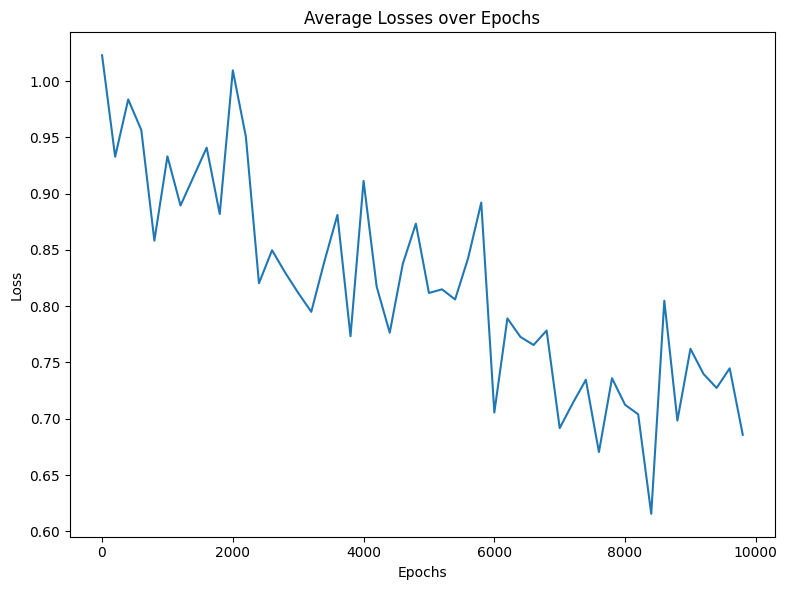

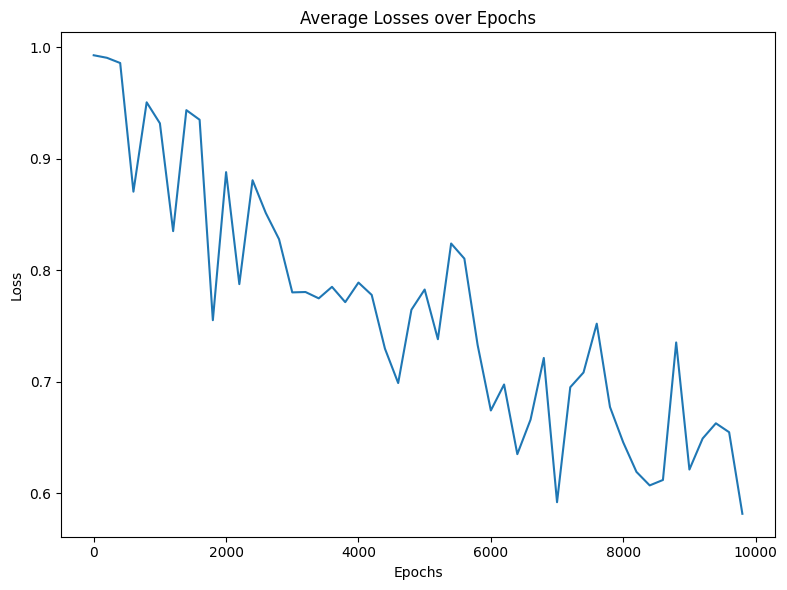

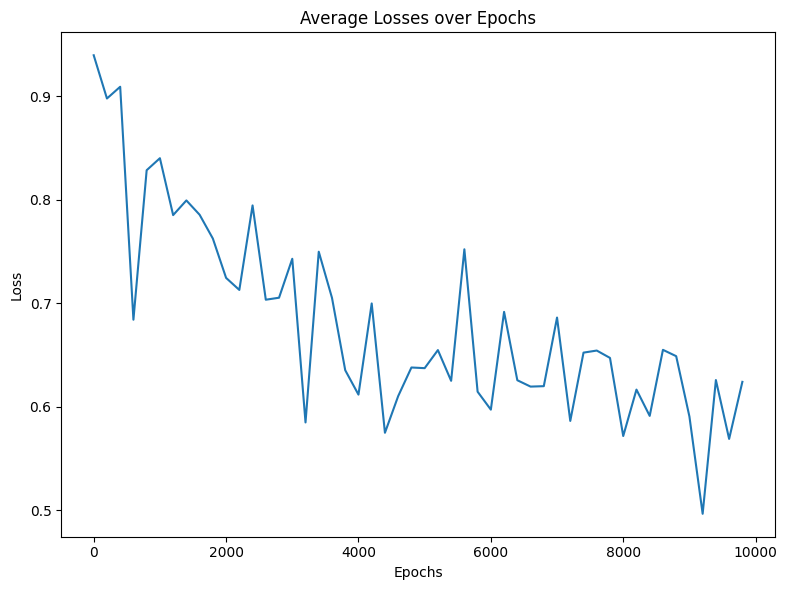

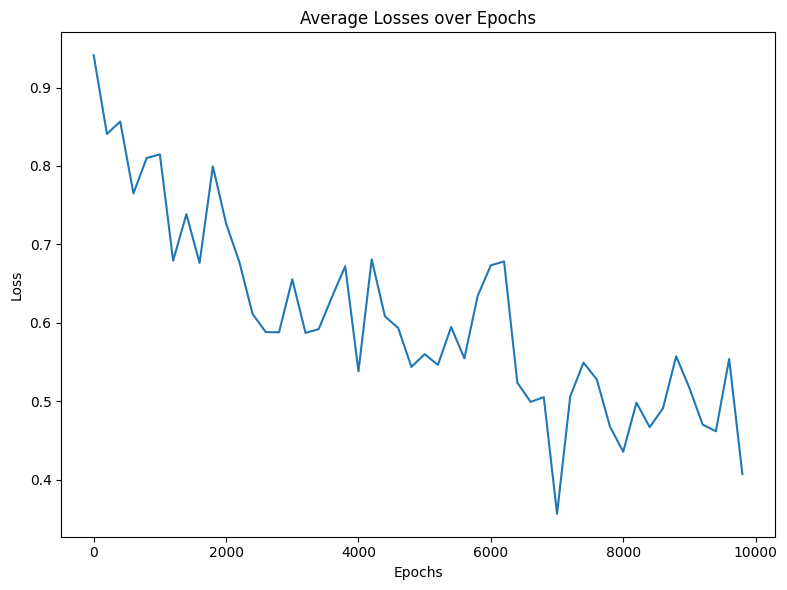

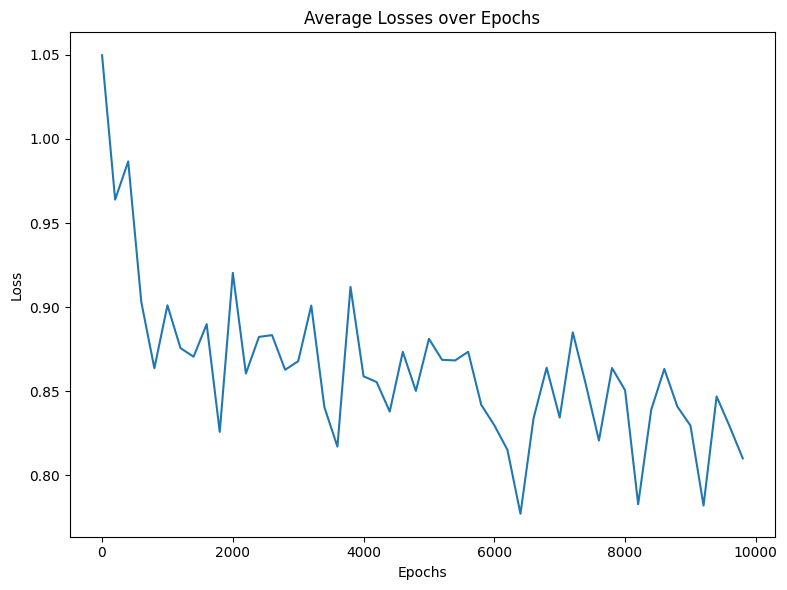

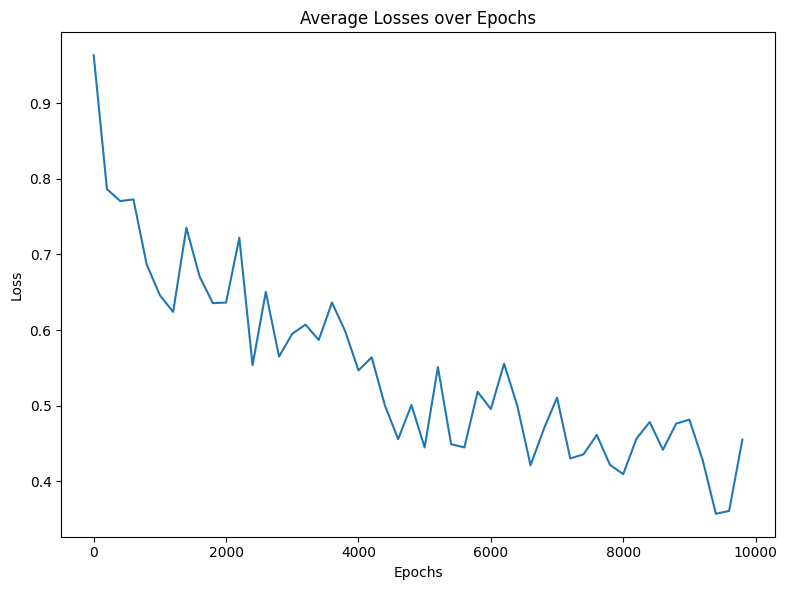

In [57]:
plot_graphs(num_epochs, plot_interval, plot_avg_losses0)
plot_graphs(num_epochs, plot_interval, plot_avg_losses1)
plot_graphs(num_epochs, plot_interval, plot_avg_losses2)
plot_graphs(num_epochs, plot_interval, plot_avg_losses3)
plot_graphs(num_epochs, plot_interval, plot_avg_losses4)
plot_graphs(num_epochs, plot_interval, plot_avg_losses5)

# 3. Testing and Evaluation

## Visualisation of Attention Weights

In [58]:
# Define custom colormap with Blue as highest values and white as lowest values
colors = [(1, 1, 1), (0.2, 0.4, 1)]  # White to Blue
cmap_name = 'custom_blue_white'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

# Function to plot attention weights for a sentence
def plot_attention(words, attention_weights, sentence, aspect, pred_polarity, true_polarity):
    # Create figure and axis
    size = len(words)
    fig, ax = plt.subplots(figsize=(size, 2)) 

    norm = plt.Normalize(vmin=0, vmax=0.1)  

    # Plot each word with attention weight as colored box
    for i, (word, weight) in enumerate(zip(words, attention_weights)):
        # Plot word
        ax.text(i, 0.5, word, ha='center', va='center', fontsize=12)

        # Plot colored box above word
        color = custom_cmap(norm(weight))
        rect = plt.Rectangle((i - 0.5, 0.6), 1, 0.4, color=color, ec='black')
        ax.add_patch(rect)

    # Set x-axis and y-axis properties
    ax.set_xlim(-0.5, len(words) - 0.5)

    # Remove x-axis and y-axis lines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Hide ticks on x-axis and y-axis
    ax.tick_params(axis='both', which='both', bottom=False, left=False)
    ax.set_xticks(range(len(words)))
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_title(f'Aspect: {aspect} | Predicted Polarity: {pred_polarity} | True Polarity: {true_polarity}', fontsize=14)

    # Add colorbar legend
    sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
    sm.set_array([])
    ax.text(-1, 0.2, sentence, ha='left', va='center', fontsize=12)
    fig.subplots_adjust(top=0.9, bottom=0.2, left=0.05, right=0.95)

    # Show plot
    plt.show()

In [59]:
# Function to get model's prediction on test data
def predict(model, sentence, aspect, integration_type):
    model.eval()
    with torch.no_grad():
        # Prepare input data for different integration types
        sent = preprocess_data([sentence])[0]
        sent_idx = [word_to_idx[word] for word in sent]
        aspect_idx = word_to_idx[aspect]
        no_sep_idx = combine_sentence_aspect(sent_idx, aspect_idx, has_sep=False)
        with_sep_idx = combine_sentence_aspect(sent_idx, aspect_idx, has_sep=True)
        rep_idx = combine_repeat_aspect(sent_idx, aspect_idx, has_sep=False)
        rep_sep_idx = combine_repeat_aspect(sent_idx, aspect_idx, has_sep=True)
        aspect_tensor = torch.LongTensor([[aspect_idx]])
        
        # Prepare input tensor and initialise encoder hidden states for different integration types
        if integration_type == NO_ASPECT:
            input_tensor = torch.LongTensor([[idx] for idx in sent_idx])
            encoder_hiddens = torch.zeros(MAX_LENGTH, model.hidden_size)
        elif integration_type == WITH_SEP:
            input_tensor = torch.LongTensor([[idx] for idx in with_sep_idx])
            encoder_hiddens = torch.zeros(MAX_COMBINED_LENGTH+1, model.hidden_size)
        elif integration_type == ASPECT_EMBED:
            input_tensor = torch.LongTensor([[idx] for idx in sent_idx])
            encoder_hiddens = torch.zeros(MAX_LENGTH, model.hidden_size)
        elif integration_type == NO_SEP:
            input_tensor = torch.LongTensor([[idx] for idx in no_sep_idx])
            encoder_hiddens = torch.zeros(MAX_COMBINED_LENGTH, model.hidden_size)
        elif integration_type == ASPECT_REP_SEP:
            input_tensor = torch.LongTensor([[idx] for idx in rep_sep_idx])
            encoder_hiddens = torch.zeros(MAX_REPSEP_LENGTH, model.hidden_size)
        elif integration_type == ASPECT_REP:
            input_tensor = torch.LongTensor([[idx] for idx in rep_idx])
            encoder_hiddens = torch.zeros(MAX_REP_LENGTH, model.hidden_size)
            
        attention_weights = []
        input_length = input_tensor.size(0)
        encoder_hidden = model.init_hidden()    # Initialise hidden states
        encoder_cell = model.init_hidden()      # Initialise cell states
        
        for ei in range(input_length):
            is_last = (ei==input_length-1)
            if is_last:
                y_output, (_, _), attn_weight  = model(input_tensor[ei], encoder_hidden, encoder_cell, encoder_hiddens, aspect_tensor, is_last=is_last)
                attention_weights.append(attn_weight)
            else:
                _, (encoder_hidden, encoder_cell), _ = model(input_tensor[ei], encoder_hidden, encoder_cell, encoder_hiddens, aspect_tensor, is_last=is_last)
                encoder_hiddens[ei] = encoder_hidden[0, 0]
            
        _, topi = y_output.topk(1)
        polarity = idx_to_polarity[topi[0].item()]
        return polarity, attention_weights, input_tensor

# Function to calculate model accuracy on test data
def evaluate(model, data_x, data_a, data_y, integration_type, visualisation=False):
    correct = 0
    for i in range(len(test_data)):
        sentence, aspect, polarity = data_x[i], data_a[i], data_y[i]
        pred_polarity, attention_weights, input_tensor = predict(model, sentence, aspect, integration_type)
        
        # Check if prediction is correct
        if pred_polarity == polarity:
            correct += 1  
            
        # Visualisation of attention weights
        if visualisation:
            if i < 8:
                input_words = [idx_to_word[idx[0]] for idx in input_tensor.tolist()]
                attn_weights = attention_weights[0].tolist()[0][0][:len(input_words)]
                words = []
                weights = []
                for i, word in enumerate(input_words):
                    if word != aspect:
                        words.append(input_words[i])
                        weights.append(attn_weights[i])
                plot_attention(words, weights, sentence, aspect, pred_polarity, polarity)

    accuracy = correct / len(test_data)
    return accuracy

## Aspect Repeat no Separator

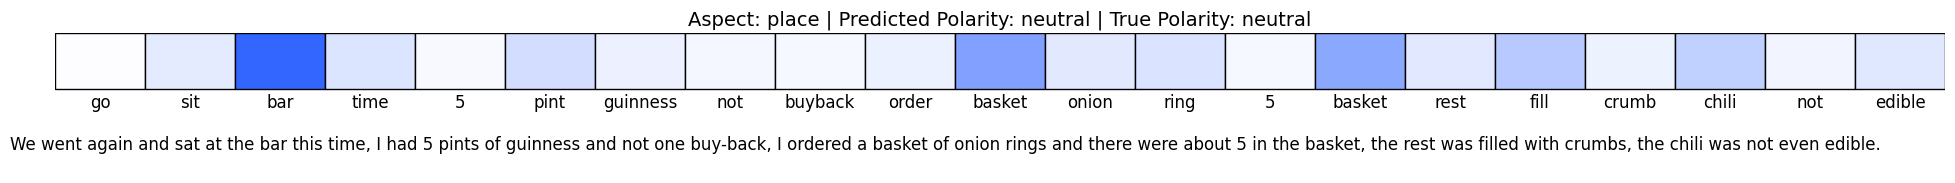

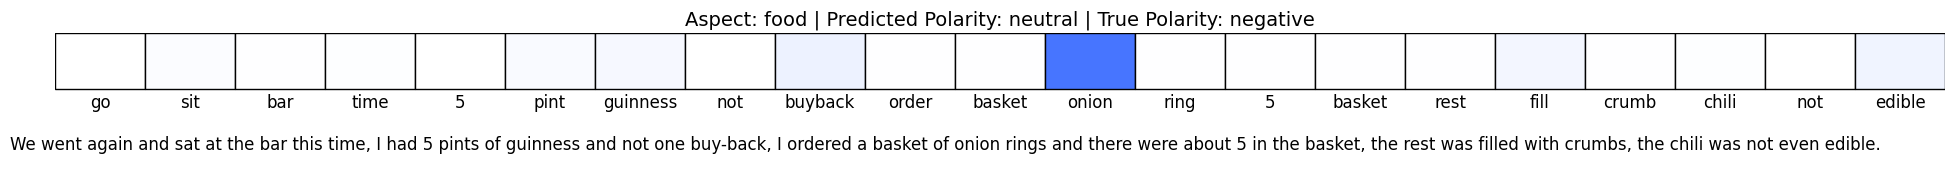

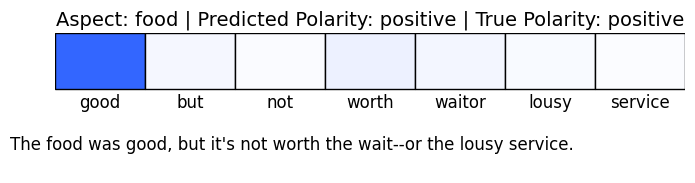

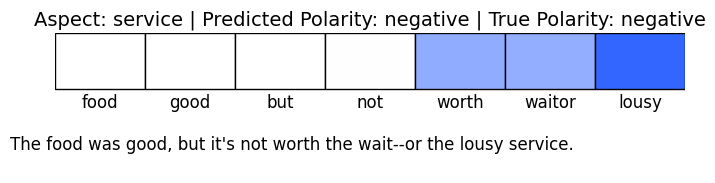

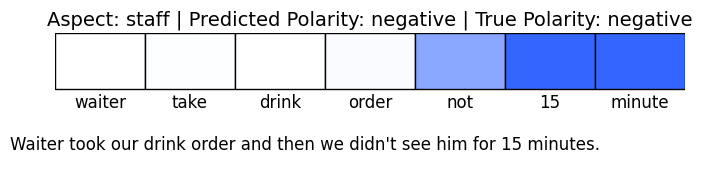

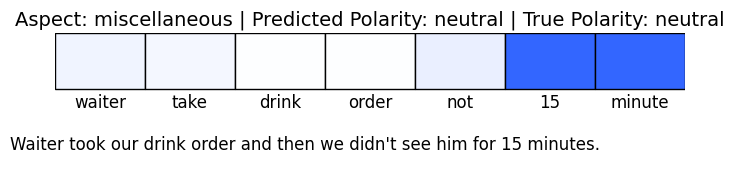

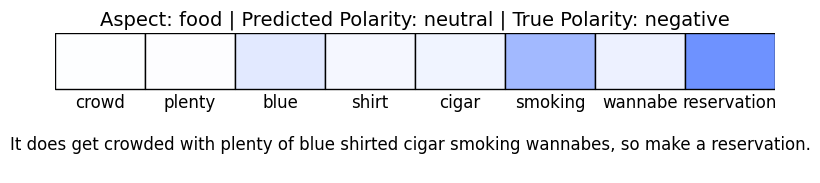

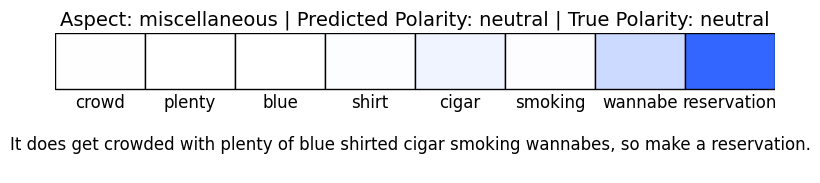

Accuracy: 0.6648


In [60]:
# Get the accuracy of the model on test data
integration_type = ASPECT_REP
accuracy0 = evaluate(model0, test_x, test_a, test_y, integration_type, visualisation=True)
print(f'Accuracy: {accuracy0:.4f}')

## Aspect Repeat with Separator

In [61]:
# Get the accuracy of the model on test data
integration_type = ASPECT_REP_SEP
accuracy0 = evaluate(model1, test_x, test_a, test_y, integration_type)
print(f'Accuracy: {accuracy0:.4f}')

Accuracy: 0.6704


## Aspect Embedding

In [62]:
# Get the accuracy of the model on test data
integration_type = ASPECT_EMBED
accuracy1 = evaluate(model2, test_x, test_a, test_y, integration_type)
print(f"Accuracy: {accuracy1:.4f}")

Accuracy: 0.6526


## With Separator

In [63]:
# Get the accuracy of the model on test data
integration_type = WITH_SEP
accuracy2 = evaluate(model3, test_x, test_a, test_y, integration_type)
print(f"Accuracy: {accuracy2:.4f}")

Accuracy: 0.6970


## No Aspect

In [64]:
# Get the accuracy of the model on test data
integration_type = NO_ASPECT
accuracy3 = evaluate(model4, test_x, test_a, test_y, integration_type)
print(f"Accuracy: {accuracy3:.4f}")

Accuracy: 0.4595


## No Separator

In [65]:
# Get the accuracy of the model on test data
integration_type = NO_SEP
accuracy4 = evaluate(model5, test_x, test_a, test_y, integration_type)
print(f"Accuracy: {accuracy4:.4f}")

Accuracy: 0.6759
